# "Segmentez des clients d'un site e-commerce"
_Cleaning Notebook_

## 0 Preliminaries

In [1]:
# !pip install flake8 pycodestyle_magic
# !pip install gtts
# !pip install category-encoders
# !pip install mlxtend==0.17.3 # makes Google Colab asking for reboot
# !pip install ppscore

In [2]:
# !pip freeze > requirements_cleaning_eda.txt

Checking for PEP8 compliance

In [3]:
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [4]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [5]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFPvAh2QI6quClGCbjb4F4OzoWOp0ipvH-LFWV7uP2pWehWBQfB0ew
Mounted at /gdrive
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [6]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_cleaning_eda.txt') \
                     and os.path.exists(os.getcwd()+'/P5_functions.py')):
        print("ERROR: Make sure 'P5_functions.py' and 'requirements_cleaning_eda.txt' are in the current working directory")

!pip install -r requirements_cleaning_eda.txt
from P5_functions import *

     |████████████████████████████████| 133kB 7.6MB/s 
     |████████████████████████████████| 6.5MB 6.9MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 143kB 55.6MB/s 
     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 92kB 7.8MB/s 
     |████████████████████████████████| 1.3MB 51.7MB/s 
     |████████████████████████████████| 1.6MB 68.0MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 153kB 55.4MB/s 
  Created wheel for featuretools: filename=featuretools-0.4.1-cp36-none-any.whl size=168821 sha256=45a5ee2bf7acb6c3600198157c15141dd910032c31be73e580621cbdd8e0a5e5
  Stored in directory: /root/.cache/pip/wheels/5e/b4/a0/0ab77ecad651fd33f8aac20d7c5d02a393f774a7eafb34f49c
  Created wheel for gTTS-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4096 sha256=5f3f36aa7401fcb7ec81f2fa2fdc9052

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importation of modules and packages. 

In [7]:
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options

In [8]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 100,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [9]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [10]:
speak('Packages and modules successfully imported')

### 0.1 Importing the Aggregated Orders dataset

Let's load the dataframe of aggregated orders as well as the dataframe of aggregated customers.

This way, we'll be able to reconstruct the dataframe of customer on different slots of time later on.

In [11]:
if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df_cust = pd.read_csv('agg_customers.csv', sep=',', index_col='customer_unique_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


All the dates and timestamps in the dataframes are to be converted.

In [12]:
# Dates are converted in datetime format, and timedeltas in timedeltas
df_orders[['order_purchase_timestamp', 'max_limit_ship_date']] = \
    df_orders[['order_purchase_timestamp', 'max_limit_ship_date']]\
        .apply(lambda x: pd.to_datetime(x))
df_orders[['shipping_time', 'shipping_delay']] = \
    df_orders[['shipping_time', 'shipping_delay']]\
        .apply(lambda x: pd.to_timedelta(x))  
df_orders['cust_region'] = \
    df_orders['cust_region'].astype('object')

# Time in df_cust are already encoded in days (int)
df_cust['cust_region'] = \
    df_cust['cust_region'].astype('object')

In [13]:
df_orders.shape

(99441, 36)

In [14]:
df_orders.columns

Index(['customer_unique_id', 'cust_region', 'order_status', 'order_purchase_timestamp',
       'order_item_nb', 'product_volume_cm3', 'product_weight_g', 'mean_prod_descr_length',
       'shipping_time', 'shipping_delay', 'max_limit_ship_date', 'delivered', 'price',
       'freight_value', 'review_score', 'review_comment_length', 'payment_installments',
       'payment_value', 'paytype_boleto', 'paytype_credit_card', 'paytype_debit_card',
       'paytype_not_defined', 'paytype_voucher', 'cat_home', 'cat_furniture', 'cat_electronics',
       'cat_office', 'cat_diy', 'cat_food', 'cat_miscellaneous', 'cat_multimedia', 'cat_fashion',
       'cat_books', 'cat_hygiene', 'cat_unknown', 'cat_leisure'],
      dtype='object')

In [15]:
df_orders.dtypes.value_counts()

float64            28
object              3
datetime64[ns]      2
timedelta64[ns]     2
int64               1
dtype: int64

In [16]:
df_cust.dtypes.value_counts()

float64    34
int64       8
object      1
dtype: int64

In [17]:
speak('Dataset successfully imported')

### 0.2 Aggregation of the customers dataset on custom time slots 

If we need to recompute the dataset in another period of time, we just need to call the function below, indicating as argument the right t_min and t_max.

In [18]:
# Aggregation in a chosen time slot
# all customers (for max period of time): (96095, 22)

# t_min = pd.Timestamp('2017-10-17 17:30:18')
# t_max = pd.Timestamp('2018-01-01 17:30:18')

def generate_cust_df(df_orders, t_min=None, t_max=None):
    df_cust = create_agg_cust_df(df_orders, t_min=t_min, t_max=t_max)
    df_cust = create_features_cust_df(df_cust)
    return df_cust

# test_df_cust = generate_cust_df(df_orders, t_min=None, t_max=None)

## 1 Clustering

### 1.1 Data preprocessing

In [19]:
# df_cust.columns

Here we use a custom transformer (see the class CustTransformer in P5_functions.py) to:
- encode categorical data with Ordinal Encoder
- Standardize the quantitative data with StandardScaler

In [20]:
# # Transformation and encoding
# ct = CustTransformer(strat_low_card='ohe',
#                      strat_quant='stand')
# ct.fit(df_cust)
# df_cust_trans = ct.transform(df_cust)

In [21]:
# df_cust_trans.columns

### 1.2 Features selection, features reduction

#### Variance Inflation Factor

We'll use the variance inflation factor (VIF) to find the colinear features in our transformed dataset.
NB: the VIF of a feature among a group of features can be defined as 1/(1-R²), where R² is the R² score of a simple regression of this features over all the others. If R² is high (and hence VIF), it means that the feature can be very well approximated using one or more of the other features, and thus is the source of colinearity.
In the "select_from_vif_" function, we eliminate the most highly correlated features and recalculate VIF of each feature. Usually, VIF should not exceed 5.

In [22]:
# select_from_vif_(df_cust_trans, thresh=0.5).columns

The columns exceeding a VIF of 5 are :
- low_card__cust_region_1', (the most frequent region)
- 'paytype_credit_card_tot_nb', (the most frequent payment)
- 'tot_comment_length', correlated with 'mean_comment_length'
- 'tot_nb_deliv_ord' and 'tot_nb_items', correlated resp. with 'tot_nb_ord' and - 'mean_nb_items_per_ord'
- 'mean_ship_delay', correlated with 'mean_ship_time'
- 'time_since_first_purch' correlated with 'time since_mast_purch'
- 'tot_price', 'tot_freight_val', 'tot_pay_value', mean_price_per_order', 'mean_pay_value_per_order', correlated with 'mean_nb_items_per_ord'

We decide to drop the foollowing columns:

In [23]:
col_vif_drop = ['time_since_first_purch', 'tot_comment_length',
                'tot_nb_deliv_ord', 'tot_nb_items', 'tot_pay_value',
                'paytype_credit_card_tot_nb', 'tot_freight_val',
                'mean_price_per_order', 'mean_pay_value_per_order',
                'mean_ship_delay']
df_cust_vif = df_cust.drop(columns=col_vif_drop)
df_cust_vif.shape

(96096, 33)

#### Low variance features

Checking for low variance features before transformation

In [24]:
# # Transformation and encoding
# ct = CustTransformer(strat_low_card='ohe', # One_Hot enc for categorical
#                      strat_quant='none') # no standardization
# df_enc = ct.fit_transform(df_cust_vif)

# thresholds = [0,0.02,0.05,0.1,5,20,100,200,300,1000,5000,10000,25000,50000]

# df_feat_var = check_feature_variance(thresholds, df_enc)

In [25]:
# plt.plot(df_feat_var['thresh']+0.0001, df_feat_var['n_rem_cols'],  '-or')

# ax = plt.gca()
# ax.set_xlabel('Variance threshold')
# ax.set_ylabel('Number of remaining columns')
# ax.set_xscale('log')
# # ax.set_yscale('log')

A lot of feature have low variance, but it is partially due to the scale of the data. Let's try several quantitative transformations to see if the variance of these data can be increased. 

In [26]:
# # Transformation and encoding
# ct1 = CustTransformer(strat_low_card='ohe', # One_Hot enc for categorical
#                      strat_quant='none') # no transformation
# df_enc = ct1.fit_transform(df_cust_vif)

# print("------STANDARDIZATION-------")
# ct2 = CustTransformer(strat_binary='ord',
#                       strat_low_card='none', 
#                       strat_quant='stand') # Standardization
# df_enc_trans_A = ct2.fit_transform(df_enc)
# th_A = np.arange(0,1.05,0.05)
# df_res_A = check_feature_variance(th_A, df_enc_trans_A)

# print("------QUANTILE NORMALISATION (norm)-------")
# ct2 = CustTransformer(strat_binary='ord',
#                       strat_low_card='none', 
#                       strat_quant='quant_norm') # Standardization
# df_enc_trans_B = ct2.fit_transform(df_enc)
# th_B = np.arange(0,1.05,0.05)
# df_res_B = check_feature_variance(th_B, df_enc_trans_B)

# print("------QUANTILE NORMALISATION (unif)-------")
# ct2 = CustTransformer(strat_binary='ord',
#                       strat_low_card='none', 
#                       strat_quant='quant_uni') # Standardization
# df_enc_trans_C = ct2.fit_transform(df_enc)
# th_C = np.arange(0,0.2,0.01)
# df_res_C = check_feature_variance(th_C, df_enc_trans_C)

In [27]:
# plt.plot(df_res_A['thresh']+0.0001, df_res_A['n_rem_cols'],
#          '-or', label='standardization', zorder=10)
# plt.plot(df_res_B['thresh']+0.0001, df_res_B['n_rem_cols'],
#          '-ob', label='quantile_trans(normal)', zorder=5)
# plt.plot(df_res_C['thresh']+0.0001, df_res_C['n_rem_cols'],
#          '-og', label='quantile_trans(uniform)', zorder=1)

# ax = plt.gca()
# ax.set_xlabel('Variance threshold')
# ax.set_ylabel('Number of remaining columns')
# # ax.set_xscale('log')
# ax.legend()
# # ax.set_yscale('log')
# plt.show()


Apart from 'mean_nb_items_per_ord' and 'single_purch, most of the low variance columns are, without surprise, dummy columns (region, payment type and category).
We will nevertheless keep the columns for the moment and try a feature selection.


#### PCA

In [28]:
# # Data selection
# sel_cols = [c for c in df_cust_vif.columns \
#             if not (('cat_' in c)\
#                     or ('paytype' in c)\
#                     or ('reg' in c))]
# print("Columns excluded :\n",
#       [c for c in df_cust_vif if c not in sel_cols])
# print("Columns included :\n", sel_cols)

# # Transformation and encoding
# ct1 = CustTransformer(strat_low_card='ohe',
#                       strat_quant='quant_norm')
# ct2 = CustTransformer(strat_quant='stand')
# df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

In [29]:
# from sklearn.decomposition import PCA

# n_comp = len(df_sel_trans.columns)
# pca = PCA(n_components=n_comp).fit(df_sel_trans)

# # Performing pca
# pca_comp = pd.DataFrame(pca.components_,
#                         index=['PC'+str(i+1) for i in range(n_comp)],
#                         columns=sel_cols).T

# # Projection of the dataframe on all pca axes
# df_proj_PCA = pd.DataFrame(pca.transform(df_sel_trans),
#                            index=df_sel_trans.index,
#                            columns=['PC'+str(i) for i in range(n_comp)])

Plotting heat map of the principal components

In [30]:
# plot_heatmap(pca_comp,'Principal components coefficients',
#              vmin=-1, vmax=1, center=0,
#              palette=sns.color_palette("coolwarm", 20),
#              figsize=(10,6),shape='rect')
# plt.show()

Plotting explained variance ratio in scree plot

In [31]:
# exp_var_rat = pca.explained_variance_ratio_
# scree_plot(col_names= pca_comp.columns, exp_var_rat=exp_var_rat,
#            ylim=(0,0.6), figsize=(14,3))
# plt.grid()
# plt.show()

Without the dummy columns, 80% of the variance of the 15 columns is in the 8 first principal components.
With a quantile transformation (normal) before the standardization, more variance can be obtained on the first axes.

#### UMAP

In [32]:
# # Data selection
# sel_cols = [c for c in df_cust_vif.columns \
#             if not (('cat_' in c)\
#                     or ('paytype' in c)\
#                     or ('reg' in c))]
# print("Columns excluded :\n",
#       [c for c in df_cust_vif if c not in sel_cols])
# print("Columns included :\n", sel_cols)

# # Transformation and encoding
# ct1 = CustTransformer(strat_low_card='ohe',
#                       strat_quant='quant_norm')
# ct2 = CustTransformer(strat_quant='stand')
# df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

In [33]:
# from umap import UMAP

# df = df_sel_trans

# n_comp = len(df.columns)

# # UMAP instantiation
# umap = UMAP(n_components=n_comp, n_neighbors=15, min_dist=0.1, init='spectral',
#             random_state=14)

# # Fitting the model, projecting data on UMAP axes
# df_proj_UMAP = pd.DataFrame(umap.fit_transform(df),
#                            index=df.index,
#                            columns=['UMAP'+str(i) for i in range(n_comp)])

### 1.4 Preparing data before clustering

In [34]:
# Sampling
ind_samp_1000 = df_cust.sample(1000, random_state=14).index
ind_samp_5000 = df_cust.sample(5000, random_state=14).index
ind_samp_10000 = df_cust.sample(10000, random_state=14).index

In [35]:
vif_cols = [c for c in df_cust.columns if c not in df_cust_vif.columns]

In [36]:
cat_cols = [c for c in df_cust.columns if ('cat_' in c)]
reg_cols = [c for c in df_cust.columns if ('reg' in c)]
pay_cols = [c for c in df_cust.columns if ('paytype' in c)]+['mean_pay_install']

In [37]:
prod_spec_cols = ['mean_prod_vol_cm3', 'mean_prod_descr_length', 'mean_prod_wei_g',
             'avg_freight_payval_ratio', 'mean_ship_delay', 'mean_ship_time']
satisf_cols = ['mean_comment_length', 'tot_comment_length', 'mean_rev_score',
               'nb_not_rec_orders']
recency_cols = ['time_since_last_purch', 'time_since_first_purch']
monetary_cols = ['mean_freight_val_per_order', 'tot_freight_val',
                 'mean_price_per_order', 'tot_price',
                 'avg_freight_payval_ratio', 'mean_pay_value_per_order',
                 'tot_pay_value']
frequency_cols = ['tot_nb_deliv_ord', 'tot_nb_ord', 'single_purch',
                  'mean_nb_items_per_ord', 'tot_nb_items']  

In [38]:
all_cols = (list(set(cat_cols + reg_cols + pay_cols + vif_cols\
                     + prod_spec_cols + satisf_cols + recency_cols\
                     + monetary_cols + frequency_cols)))

In [39]:
len(df_cust.columns), len(all_cols),\
    [c for c in df_cust.columns if c not in all_cols]

(43, 43, [])

#### All the variables (df1_1)

In [40]:
# Data selection
df1_1 = df_cust[all_cols]
# Transformation and encoding
ct1 = CustTransformer(strat_low_card='ohe',
                      strat_quant='none')
df1_1 = ct1.fit_transform(df1_1)

# Transformation and encoding
ct2 = CustTransformer(strat_quant='quant_norm')

df1_1_trans = ct2.fit_transform(df1_1)

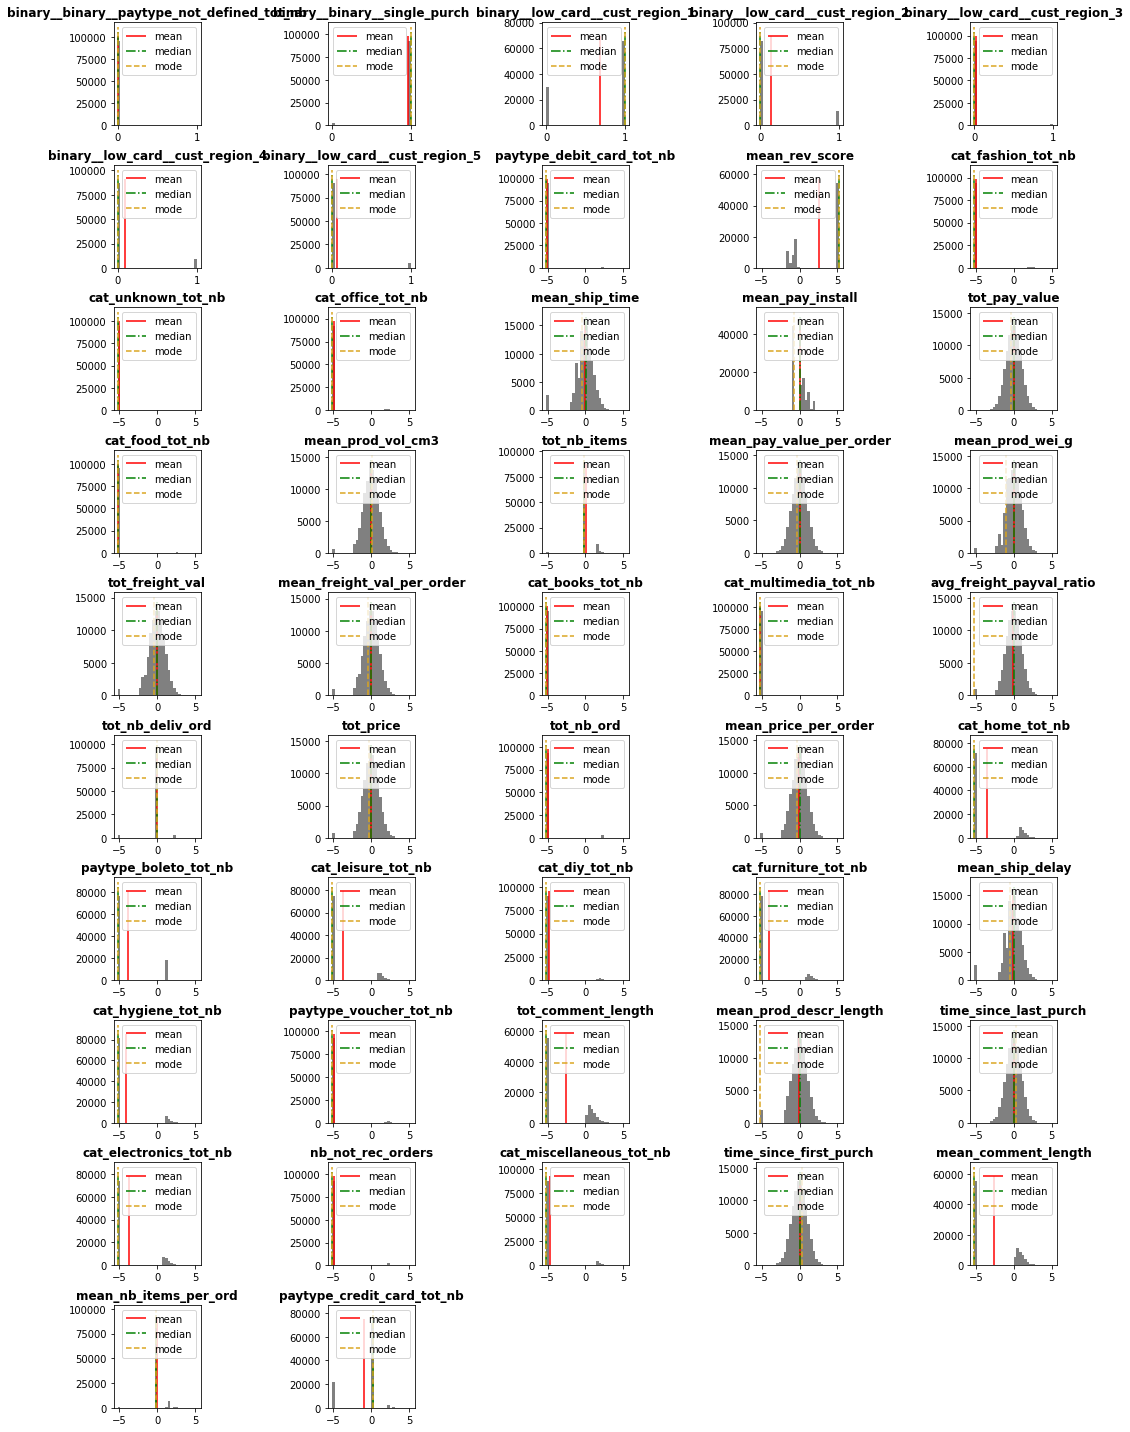

In [41]:
# Histograms of the transformed data
plot_histograms(df=df1_1_trans, cols=df1_1_trans.columns,
                figsize=(15,20), bins=30, layout=(10,5))

#### All the variable, UMAP 10 comp (df1_2)

In [42]:
# Data selection
df1_2 = df_cust[all_cols]

# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='none')
df1_2 = ct.fit_transform(df1_2)

In [43]:
from umap import UMAP

n_comp = 10
umap = UMAP(n_components=n_comp, n_neighbors=15, min_dist=0.1, init='spectral',
            random_state=14)

# Fitting the model, projecting data on UMAP axes
df1_2_trans = pd.DataFrame(umap.fit_transform(df1_2),
                            index=df1_2.index,
                            columns=['UMAP'+str(i) for i in range(n_comp)])

In [44]:
# Transformation and encoding
ct = CustTransformer(strat_quant='quant_norm')

df1_2_trans = ct.fit_transform(df1_2_trans)

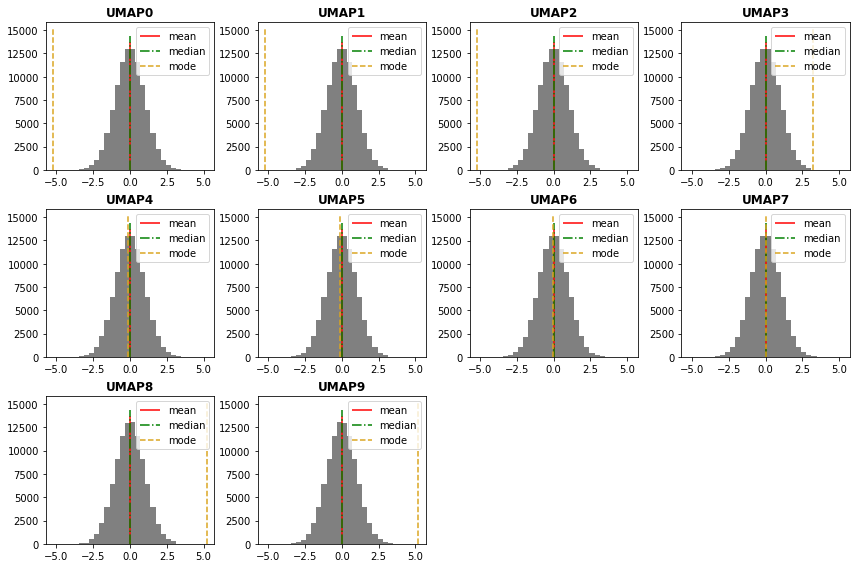

In [45]:
# Histograms of the transformed data
plot_histograms(df=df1_2_trans, cols=df1_2_trans.columns,
                figsize=(12,8), bins=30, layout=(3,4))

#### All RFM features (df2_1)

In [46]:
# Data selection
sel_cols_2_1 = recency_cols\
            + frequency_cols\
            + monetary_cols

df2_1 = df_cust[sel_cols_2_1]

sel_cols_2_1

['time_since_last_purch',
 'time_since_first_purch',
 'tot_nb_deliv_ord',
 'tot_nb_ord',
 'single_purch',
 'mean_nb_items_per_ord',
 'tot_nb_items',
 'mean_freight_val_per_order',
 'tot_freight_val',
 'mean_price_per_order',
 'tot_price',
 'avg_freight_payval_ratio',
 'mean_pay_value_per_order',
 'tot_pay_value']

In [47]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                     strat_quant='quant_norm')

df2_1_trans = ct.fit_transform(df2_1)

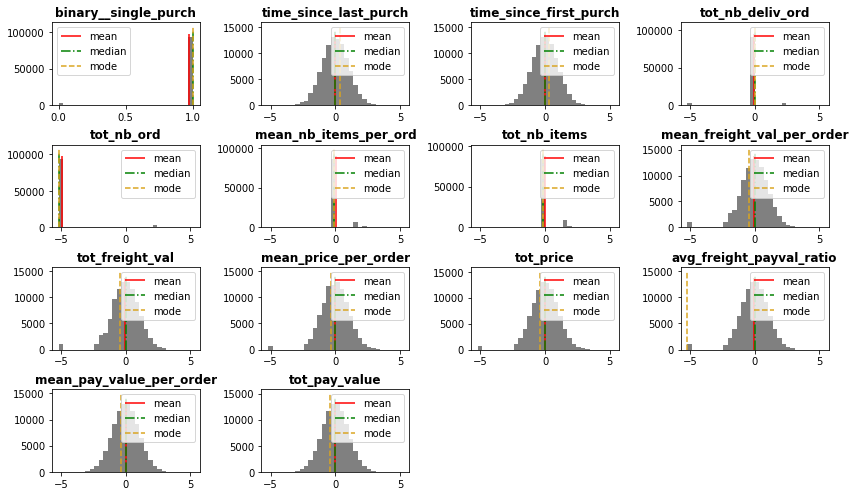

In [48]:
# Histograms of the transformed data
plot_histograms(df=df2_1_trans, cols=df2_1_trans.columns,
                figsize=(12,7), bins=30, layout=(4,4))

#### All RFM + paytype (df2_2)

In [49]:
# Data selection
sel_cols_2_2 = recency_cols\
            + frequency_cols\
            + pay_cols\
            + monetary_cols

df2_2 = df_cust[sel_cols_2_2]

sel_cols_2_2

['time_since_last_purch',
 'time_since_first_purch',
 'tot_nb_deliv_ord',
 'tot_nb_ord',
 'single_purch',
 'mean_nb_items_per_ord',
 'tot_nb_items',
 'paytype_not_defined_tot_nb',
 'paytype_boleto_tot_nb',
 'paytype_voucher_tot_nb',
 'paytype_debit_card_tot_nb',
 'paytype_credit_card_tot_nb',
 'mean_pay_install',
 'mean_freight_val_per_order',
 'tot_freight_val',
 'mean_price_per_order',
 'tot_price',
 'avg_freight_payval_ratio',
 'mean_pay_value_per_order',
 'tot_pay_value']

In [50]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df2_2_trans = ct.fit_transform(df2_2)

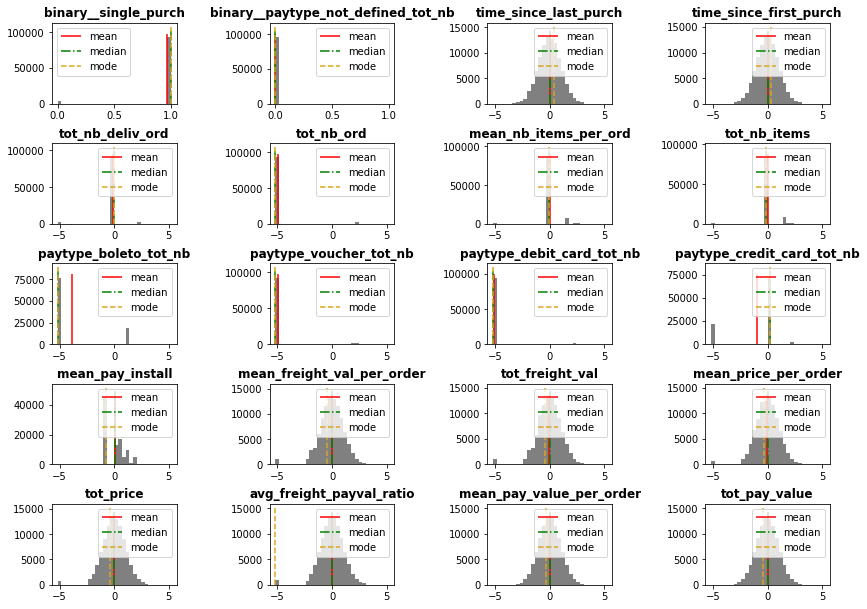

In [51]:
# Histograms of the transformed data
plot_histograms(df=df2_2_trans, cols=df2_2_trans.columns,
                figsize=(12,10), bins=30, layout=(6,4))

#### Selection RFM features (df2_3)

We want to a a first clustering based on the value, seniority and loyalty of a  customer. These qualities are defined by the typical RFM analysis (Recency, Frequency, Monetary). In our database, we can use the following features:
- Recency: 'time_since_first_purch'
- Monetary: 'tot_price'
- Frequency: 'tot_nb_ord', 'single_purch', 'time_since_last_purch'

NB: We know that the 'Frequency' will be the more difficult to apprehend, since the great majority of the customers had only one order, that's why we keep the three features as they are.

In [52]:
# Data selection
sel_cols_2_3 = ['tot_nb_ord', 'tot_price',
                'time_since_last_purch', 'time_since_first_purch']

df2_3 = df_cust[sel_cols_2_3]

In [53]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df2_3_trans = ct.fit_transform(df2_3)

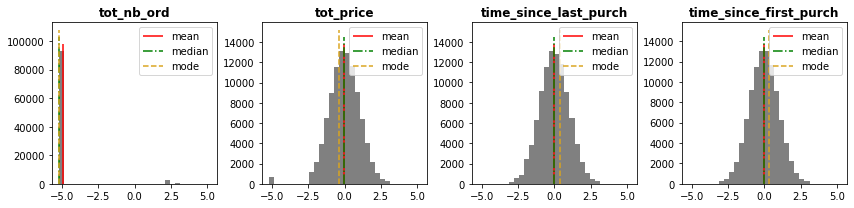

In [54]:
# Histograms of the transformed data
plot_histograms(df=df2_3_trans, cols=df2_3_trans.columns,
                figsize=(12,3), bins=30, layout=(1,4))

#### Product spec, review and monetary (df3_1)

In [55]:
# Data selection
sel_cols_3_1 = list(set(prod_spec_cols\
                + satisf_cols\
                + monetary_cols))

df3_1 = df_cust[sel_cols_3_1]

sel_cols_3_1

['mean_price_per_order',
 'mean_prod_descr_length',
 'tot_comment_length',
 'mean_rev_score',
 'mean_prod_wei_g',
 'mean_pay_value_per_order',
 'nb_not_rec_orders',
 'mean_freight_val_per_order',
 'mean_ship_time',
 'tot_freight_val',
 'avg_freight_payval_ratio',
 'mean_comment_length',
 'mean_ship_delay',
 'tot_pay_value',
 'mean_prod_vol_cm3',
 'tot_price']

In [56]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df3_1_trans = ct.fit_transform(df3_1)

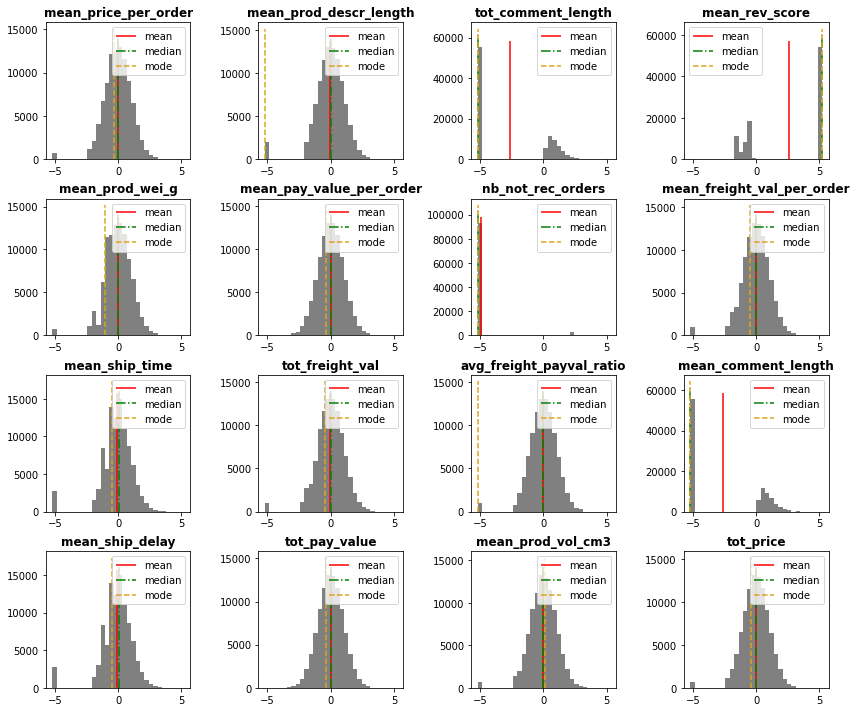

In [57]:
# Histograms of the transformed data
plot_histograms(df=df3_1_trans, cols=df3_1_trans.columns,
                figsize=(12,10), bins=30, layout=(4,4))

#### Product spec, satisfaction and monetary + category (df3_2)

In [58]:
# Data selection
sel_cols_3_2 = list(set(prod_spec_cols\
                + cat_cols\
                + satisf_cols\
                + monetary_cols))

df3_2 = df_cust[sel_cols_3_2]

sel_cols_3_2

['mean_rev_score',
 'cat_fashion_tot_nb',
 'cat_unknown_tot_nb',
 'mean_ship_time',
 'cat_office_tot_nb',
 'tot_pay_value',
 'cat_food_tot_nb',
 'mean_prod_vol_cm3',
 'mean_prod_wei_g',
 'mean_pay_value_per_order',
 'mean_freight_val_per_order',
 'tot_freight_val',
 'cat_books_tot_nb',
 'cat_multimedia_tot_nb',
 'avg_freight_payval_ratio',
 'tot_price',
 'mean_price_per_order',
 'cat_home_tot_nb',
 'cat_leisure_tot_nb',
 'cat_diy_tot_nb',
 'cat_furniture_tot_nb',
 'mean_ship_delay',
 'cat_hygiene_tot_nb',
 'mean_prod_descr_length',
 'tot_comment_length',
 'cat_electronics_tot_nb',
 'nb_not_rec_orders',
 'cat_miscellaneous_tot_nb',
 'mean_comment_length']

In [59]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df3_2_trans = ct.fit_transform(df3_2)

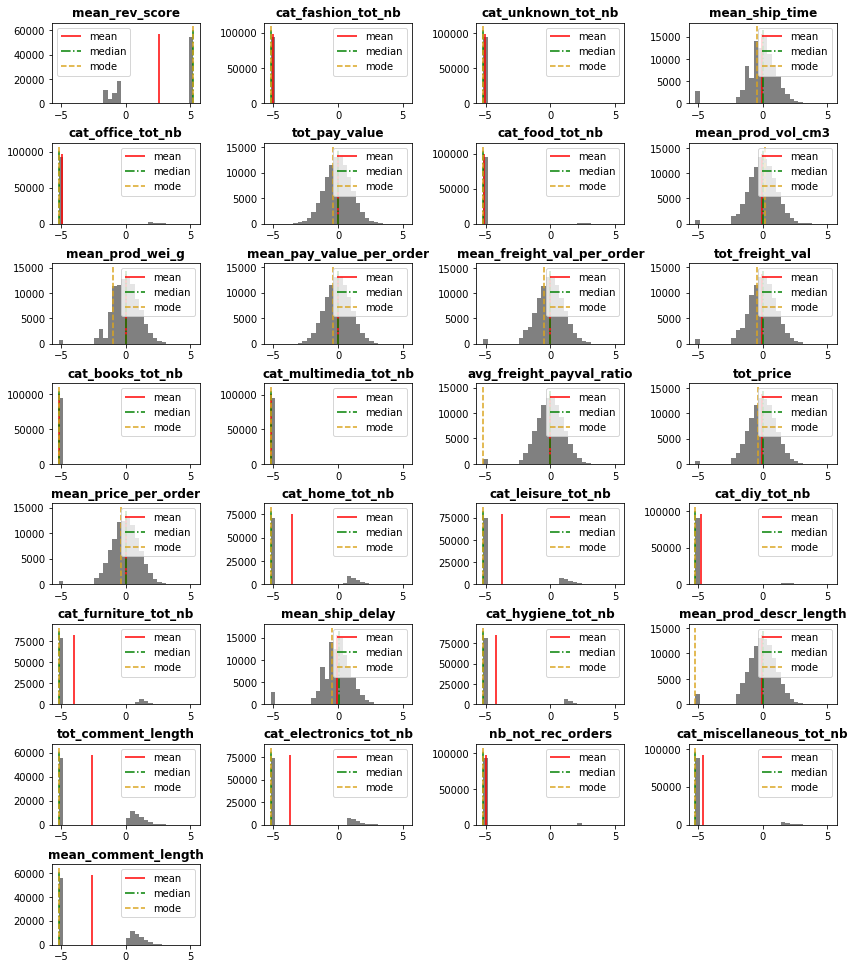

In [60]:
# Histograms of the transformed data
plot_histograms(df=df3_2_trans, cols=df3_2_trans.columns,
                figsize=(12,15), bins=30, layout=(9,4))

#### Selection Product spec, review and monetary (df3_3)


In [61]:
# Data selection
sel_cols_3_3 = ['mean_pay_value_per_order', 'avg_freight_payval_ratio', 
                'nb_not_rec_orders', 'mean_prod_wei_g', 'mean_comment_length', 
                'mean_rev_score', 'mean_prod_vol_cm3', 'mean_prod_descr_length',
                'tot_price', 'tot_comment_length', 'mean_ship_delay']

df3_3 = df_cust[sel_cols_3_3]

In [62]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df3_3_trans = ct.fit_transform(df3_3)

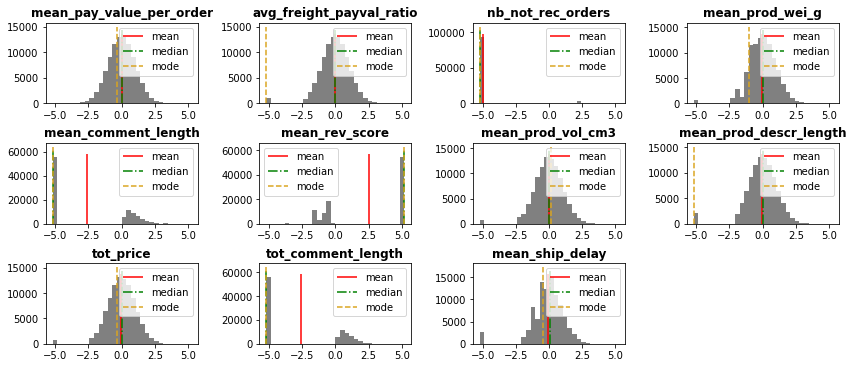

In [63]:
# Histograms of the transformed data
plot_histograms(df=df3_3_trans, cols=df3_3_trans.columns,
                figsize=(12,15), bins=30, layout=(9,4))

### 1.3 Preparing the axes for visualisation

In [64]:
df=df3_1_trans.loc[ind_samp_5000]

#### PCA

In [237]:
# PCA

from sklearn.decomposition import PCA

# Performing pca
pca = PCA(n_components=2).fit(df)

# Projection of the sample dataframe on the 2 first pca axes
df_proj_PCA_2D = pd.DataFrame(pca.transform(df),
                              index=df.index,
                              columns=['PC'+str(i) for i in range(2)])

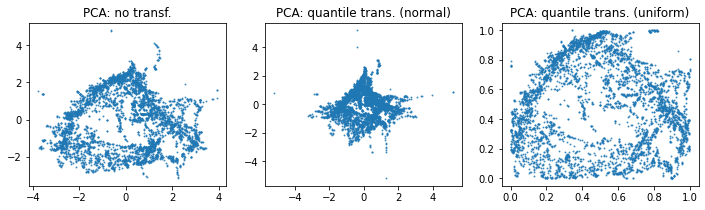

In [238]:
plot_projection(df_proj_PCA_2D,
                # ser_clust=ser_clust,
                quant_transf=True,
                figsize=(12,3), title='PCA')

#### UMAP

In [225]:
# # UMAP

# from umap import UMAP

# # Instantiation of UMAP
# umap = UMAP(n_components=2, random_state=14)

# # Projection of the dataframe on the 2 UMAP axes
# df_proj_UMAP_2D = pd.DataFrame(umap.fit_transform(df),
#                                index=df.index,
#                                columns=['UMAP'+str(i) for i in range(2)])

In [226]:
# plot_projection(df_proj_UMAP_2D,
#                 # ser_clust=ser_clust,
#                 quant_transf=True,
#              figsize=(12,3), title='UMAP')

In [227]:
# # TESTING FOR n_neighbors=15

# ind_sample = df_cust_trans.sample(1000, random_state=14).index

# fig = plt.figure(figsize=(18,3))
# n_neigh_list = [5, 10, 20, 50, 100, 200]
# for i, n in enumerate(n_neigh_list,1):
#     draw_umap(data=df,
#             #   ser_clust=ser_clust.loc[ind_sample],#
#               n_neighbors=n,
#               fig=fig,
#               layout=str(1)+str(len(n_neigh_list))+str(i),
#               title='n_neighbors = {}'.format(n),
#               s=1, alpha=0.6,
#               random_state=14)
# fig.suptitle("UMAP : Testing for best nb neighbors",
#              fontsize=16, fontweight='bold')
# plt.tight_layout(rect=[0,0,1,0.9])
# plt.show()

# # TESTING FOR min_dist=0.1

# fig = plt.figure(figsize=(18,3))
# min_dist_list = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
# for i, d in enumerate(min_dist_list,1):
#     draw_umap(data=df,
#             #   ser_clust=ser_clust.loc[ind_sample],#
#               n_neighbors=100, min_dist=d,
#               fig=fig,
#               layout=str(1)+str(len(min_dist_list))+str(i),
#               title='min_dist = {}'.format(d),
#               s=1, alpha=0.6,
#               random_state=14)
# fig.suptitle("UMAP : Testing for best min distance",
#              fontsize=16, fontweight='bold')
# plt.tight_layout(rect=[0,0,1,0.9])
# plt.show()

In [228]:
# # TESTING FOR n_components

# fig = plt.figure(figsize=(18,5))
# n_comp_list = [1,2,3]
# for i, a in enumerate(n_comp_list,1):
#     draw_umap(data=df_cust_trans.loc[ind_sample],
#             #   ser_clust=ser_clust.loc[ind_sample],#
#               n_neighbors=100, min_dist=0.8,
#               n_components=a,
#               fig=fig, layout=str(1)+str(len(n_comp_list))+str(i),
#               title='min_dist = {}'.format(a),
#               s=3, alpha=0.6,
#               random_state=14)
# fig.suptitle("UMAP : Testing for best min distance",
#              fontsize=16, fontweight='bold')
# plt.tight_layout(rect=[0,0,1,0.9])
# plt.show()

#### t-SNE

In [240]:
# t-SNE

from sklearn.manifold import TSNE

# Fitting the model
tsne = TSNE(n_components=2, random_state=14)

# Projection of the dataframe on the 2 t-SNE axes
df_proj_tSNE_2D = pd.DataFrame(tsne.fit_transform(df),
                               index=df.index,
                               columns=['t-SNE'+str(i) for i in range(2)])

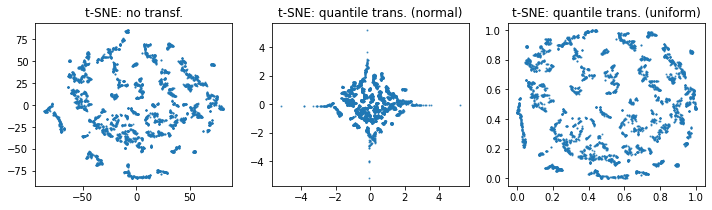

In [241]:
plot_projection(df_proj_tSNE_2D,
                # ser_clust=ser_clust,
                quant_transf=True,
                figsize=(12,3), title='t-SNE')

#### Quick function for 3 projections

In [69]:
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE

def prepare_2D_axes(df):
    # PCA
    pca = PCA(n_components=2).fit(df)
    df_proj_PCA_2D = pd.DataFrame(pca.transform(df),
                                  index=df.index,
                                  columns=['PC'+str(i) for i in range(2)])
    # UMAP
    umap = UMAP(n_components=2, random_state=14)
    df_proj_UMAP_2D = pd.DataFrame(umap.fit_transform(df),
                                   index=df.index,
                                   columns=['UMAP'+str(i) for i in range(2)])
    # t-SNE
    tsne = TSNE(n_components=2, random_state=14)
    df_proj_tSNE_2D = pd.DataFrame(tsne.fit_transform(df),
                                   index=df.index,
                                   columns=['t-SNE'+str(i) for i in range(2)])
    dict_proj = dict({'PCA': df_proj_PCA_2D,
                      'UMAP': df_proj_UMAP_2D,
                      't-SNE': df_proj_tSNE_2D})
    return dict_proj

In [232]:
dict_proj = prepare_2D_axes(df)

### 1.5 KMeans clustering

In [233]:
# from sklearn.cluster import KMeans
# n=6
# km = KMeans(n_clusters=n, n_jobs=-1)
# km.fit(df)
# ser_clust = pd.Series(data=km.labels_,
#                       index=df.index)

# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
# silh = silhouette_score(X=df,
#                         labels=ser_clust)
# dav_bould = davies_bouldin_score(X=df, labels=ser_clust)
# cal_harab = calinski_harabasz_score(X=df, labels=ser_clust)
# distor = km.inertia_
# silh, dav_bould, distor

#### Evaluation of the clustering scores

In [65]:
df = df3_1_trans.loc[ind_samp_5000]

We'll try to find the best number of cluster against:

- **Silhouette score**: measures the difference between the intra-cluster and nearest-cluster mean square distances (to maximize)
- **Davies_Bouldin score**: measures the maximal ratio of dispersion of pairs of clusters to their distance (to minimize)
- **Calinski_Harabasz score**: the ratio of inter-cluster dispersion to intra-cluster dispersion (to maximize)
- **Distortion**: the mean sum of squared distances to centers (find an elbow)

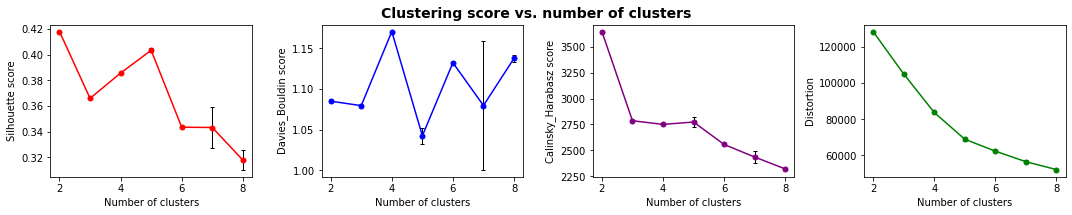

In [66]:
df_res = plot_clust_scores_vs_n_clust(df, n_clust=range(2,9),
                                       n_iter=20, figsize=(15,3))
# df_res

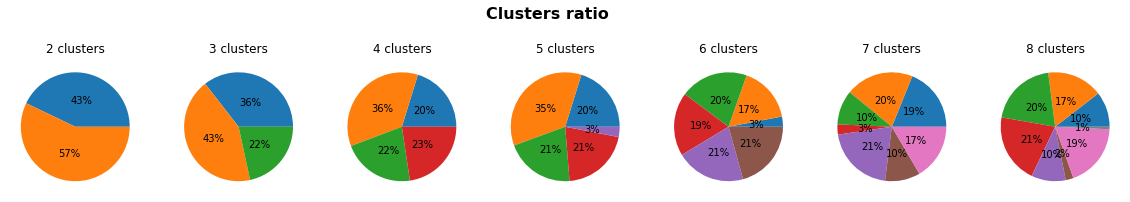

In [67]:
clusters_ratio(df, n_clust=range(2,9), figsize=(20,3.5))

#### Silhouette scores of each cluster

Let's now see in more details the silhouette scores of each cluster, for the different number of clusters.

On the left part of the graph, the silhouette coefficient is plotted for each number of clusters:
- the length of the bands is proportionnal to the size of the cluster
- the width of the small bars are the distance of each point to the closest centroid

On the right a representation of the clusters on UMAP projection of the data.

In [70]:
dict_proj = prepare_2D_axes(df)

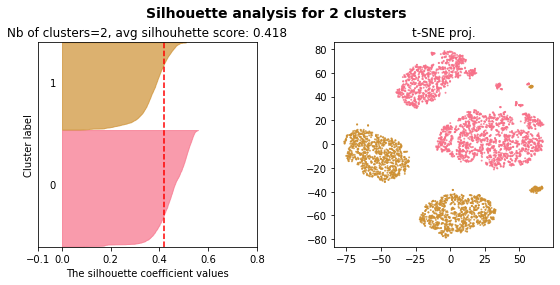

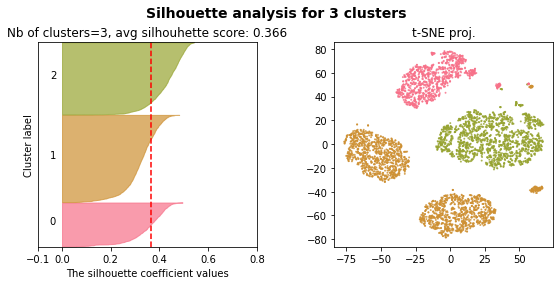

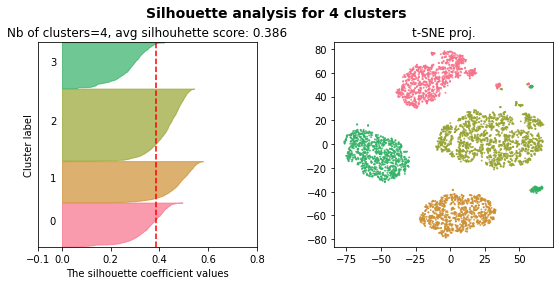

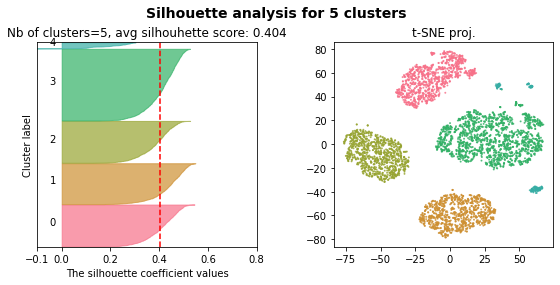

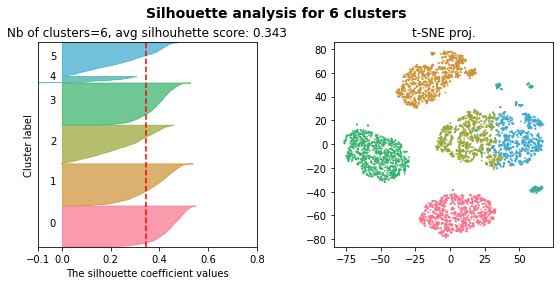

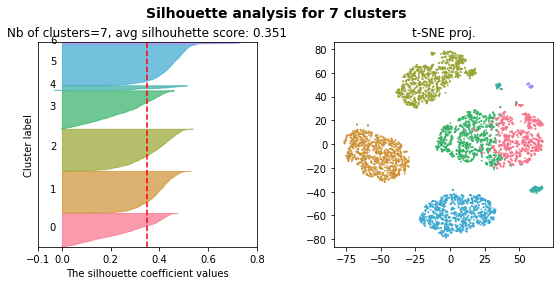

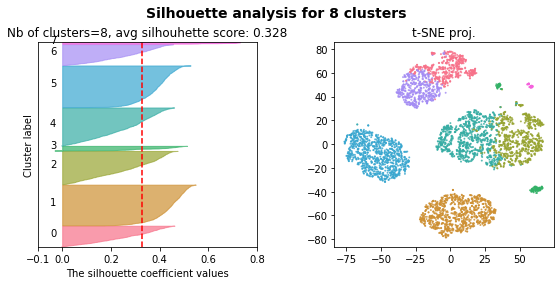

In [71]:
silh_scores_vs_n_clust(df, n_clust=[2,3,4,5,6,7,8], axis_2D=dict_proj['t-SNE'],
                       xlim=(-0.1,0.8), figsize=(8,4), title='t-SNE proj.')

In [139]:
''' Plots on the left the silhouette scores of each cluster and
on the right the projection of the points with cluster labels as cluster'''

from sklearn.metrics import silhouette_score, silhouette_samples

def silh_scores_vs_n_clust(df, n_clust, axis_2D, title='',
                           xlim=(-0.1, 0.8), figsize=(18, 3)):
    palette = sns.color_palette("Set2", max(n_clust))
    colors_2 = palette.as_hex()

    distor = []
    for n in n_clust:
        fig = plt.figure(1, figsize=figsize)

        # --- Plot 1: Silhouette scores
        ax1 = fig.add_subplot(121)

        km = KMeans(n_clusters=n, random_state=14)
        ser_clust = km.fit_predict(df)
        distor.append(km.inertia_)

        sample_silh_val = silhouette_samples(df, ser_clust)

        y_lower = 10
        for i in range(n):
            # Aggregate and sort silh scores for samples of clust i
            ith_clust_silh_val = sample_silh_val[ser_clust == i]
            ith_clust_silh_val.sort()
            size_cluster_i = ith_clust_silh_val.shape[0]
            y_upper = y_lower + size_cluster_i
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0,
                              ith_clust_silh_val,
                              facecolor=colors_2[i],
                              edgecolor=colors_2[i],
                              alpha=0.7)

            # Label of silhouette plots with their clust. nb. at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Computes the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        silhouette_avg = silhouette_score(df, ser_clust)
        ax1.set_title("Nb of clusters={}, avg silhouhette score: {:.3f}" \
                      .format(n, silhouette_avg), fontsize=12)
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        ax1.set_xlim(list(xlim))
        # (n+1)*10: inserting blank spaces between clusters silh scores
        ax1.set_ylim([0, df.shape[0] + (n + 1) * 10])

        # --- Plot 1: Showing clusters on chosen projection
        ax2 = fig.add_subplot(122)
        
        colors = None if ser_clust is None else \
            [colors_2[x] for x in ser_clust.astype('int')] # [sns.color_palette()[x] for x in ser_clust.astype('int')]

        ax2.scatter(axis_2D.iloc[:, 0], axis_2D.iloc[:, 1],
                    s=1, alpha=0.7, c=colors)
        ax2.set_title(title, fontsize=12)

        ### A REPARER --- TRACAGE DES CENTROIDES SUR LES GRAPHES A INCLURE dans la fonction plot_projection
        # # Showing centers of the clusters
        # for i in n_clust:
        #     centers = km.cluster_centers_
        #     ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
        #                 marker='o', c="white", alpha=1, s=200, edgecolor='k')
        #     for i, c in enumerate(centers):
        #         ax2.scatter(c[0], c[1], c[2], marker='$%d$' % i,
        #                     alpha=1, s=50, edgecolor='k')
        plt.suptitle("Silhouette analysis for {} clusters".format(n),
                     fontsize=14, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

#### Visualisation of the best clusters

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [72]:
from sklearn.cluster import KMeans

n=5
km = KMeans(n_clusters=n, n_jobs=-1)
km.fit(df)
ser_clust = pd.Series(data=km.labels_,
                      index=df.index)

silh = silhouette_score(X=df, labels=ser_clust)
dav_bould = davies_bouldin_score(X=df, labels=ser_clust)
cal_harab = calinski_harabasz_score(X=df, labels=ser_clust)
distor = km.inertia_
silh, dav_bould, distor

(0.40370155123483165, 1.0447739905033102, 68787.89487505717)

In [ ]:
# ### EBAUCHE TRACAGE DES CENTROIDES
# n = 3
# centroid_df = pd.DataFrame(data = km.cluster_centers_,
#                            columns = df4.columns,
#                            index = ['centroid_'+str(i) for i in range(1,n+1)])
# test = pd.concat([df4, centroid_df], 0)
# test.loc[['centroid_'+str(i) for i in range(1,n+1)]]

In [355]:
dict_proj = prepare_2D_axes(df)

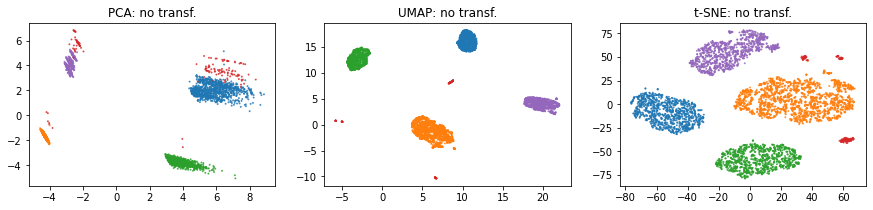

In [73]:
fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(131)
plot_projection(dict_proj['PCA'], ser_clust=ser_clust, quant_transf=False,
                title='PCA', fig=fig, ax=ax1)

ax2 = fig.add_subplot(132)
plot_projection(dict_proj['UMAP'], ser_clust=ser_clust, quant_transf=False,
                title='UMAP', fig=fig, ax=ax2)

ax3 = fig.add_subplot(133)
plot_projection(dict_proj['t-SNE'], ser_clust=ser_clust, quant_transf=False,
                title='t-SNE', fig=fig, ax=ax3)
plt.show()

#### Checking for the stability of the clusters

In [ ]:
stab_init_kmeans = stability(km, df, n_iter=20)

In [ ]:
stab_df = pd.DataFrame({'init': stab_init_kmeans})
stab_df.boxplot(color='k', vert=False)
plt.gcf().set_size_inches(7,1.5)

## 2 Clusters analysis

#### Contingency table, Chi square scores (clusters vs. binarized features)

In [358]:
df_expl = df3_3

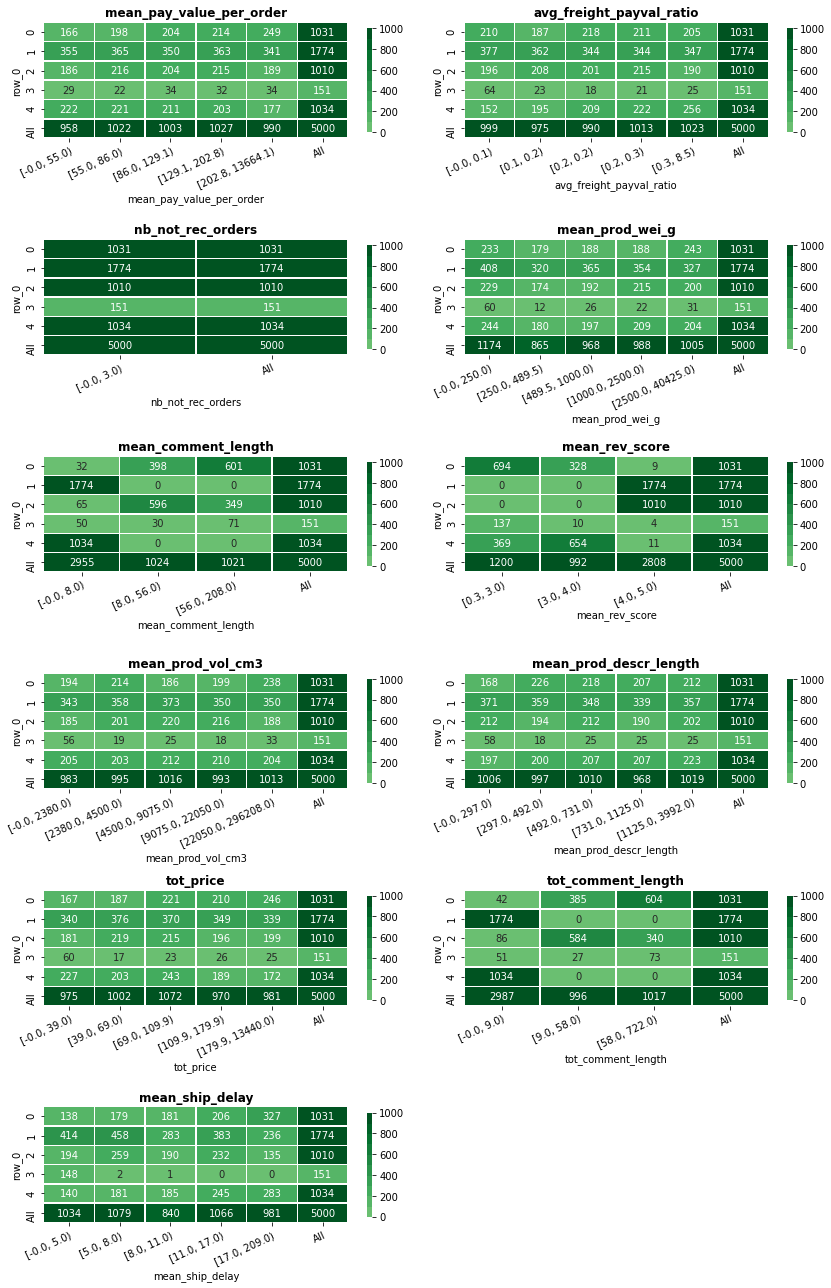

In [360]:
## Creating table of contingency and computes chi2 score

from scipy.stats import chi2_contingency

nb_ax = len(df_expl.columns)
n_rows = (nb_ax+1)//2
fig = plt.figure(figsize=(12,3*n_rows))

for i, col in enumerate(df_expl.columns, 1):
    
    ser_bin = pd.qcut(df_expl[col], [0,0.2,0.4,0.6,0.8,1], duplicates='drop') 
    data_crosstab = pd.crosstab(ser_clust, ser_bin, margins = True)

    ## Computes and prints Chi-sqare score
    stat, p, dof, expected = chi2_contingency(data_crosstab)
    res_str = 'Probably indep.' if p > 0.05 else 'Probably dep.'
    res_str = 'Chi²: stat={:.3f}, p={:.3f}, {}'.format(stat, p, res_str)

    ax = fig.add_subplot(n_rows, 2, i)
    plot_heatmap(data_crosstab, vmin=0, vmax=1000, title=col,
                #  title=f"Contingency table ('{col}' vs. 'cluster')\n"+res_str,
                 palette=sns.color_palette("Greens", 20),
                shape='rect', fmt='.0f', fig=fig, ax=ax)
    digit_round = 1
    list_interval = [x.get_text() for x in ax.get_xticklabels()] 
    str_intervals = [i.replace("(","").replace("]", "").split(", ")\
                        for i in list_interval]
    rounded_cuts = ["["+str(round(float(i),digit_round))\
                        +", "+str(round(float(j),digit_round))+")"\
                        for i, j in str_intervals[:-1]]+['All']
    ax.set_xticklabels(rounded_cuts)
plt.tight_layout()
plt.show()

In [307]:
def mean_dev_clust(model, df, orig_df, palette='seismic', figsize=(20, 3)):
    # Assign segment to each customer in original dataset
    data_with_clust = orig_df.assign(cluster=model.labels_)
    k = data_with_clust['cluster'].nunique()

    # Compute average for each feature by cluster
    kmeans_averages = data_with_clust.groupby(['cluster']).mean().round(2)
    print('Mean val for each cluster: ')
    display(kmeans_averages)
    print("\n")

    # Ratio of difference between mean and cluster means for each feature
    rel_var = 100 * (kmeans_averages - orig_df.mean()) \
                    / (orig_df.mean() + 0.1)

    # Plotting figure
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    vlim = np.array([abs(rel_var.min().min()),
                     abs(rel_var.max().max())]).max()
    sns.heatmap(data=rel_var,
                vmin=-vlim, vmax=vlim,
                center=0, annot=True, fmt='.0f',
                cmap=palette, ax=ax1)
    ax1.set_title('Mean deviation to the mean (%)', pad=20)
    ax1.set_ylabel(ylabel='cluster', labelpad=20)
    return rel_var

In [ ]:
rel_var = mean_dev_clust(km, df, df_cust.loc[df.index],
                            palette='seismic', figsize=(24,2))

#### ANOVA and Kruskal-Wallis test with quantitative data

Let's see if the quantitative columns are significant features of the clustering.

At first we'll plot the distribution of the quantitative features for each cluster as boxplots.

In [ ]:
# Plotting boxplot of quantitative features for each cluster

fig = plt.figure(figsize=(10,8))
with sns.color_palette('dark'):
    for i, c in enumerate(df.columns,1):
        ax = fig.add_subplot(3,3,i)
        sns.boxplot(data=df.assign(clust=ser_clust),
                    x='clust', y=c, width=0.5, ax=ax)
        min = df[c].mean()-5*df[c].std()
        max = df[c].mean()+5*df[c].std()
        plt.ylim(min,max)
        plt.grid()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Dispersion of quantitative data through clusters',
             fontsize=16, fontweight='bold')
plt.show()

Then we'll see if the features are significantly different between the clusters.

In [ ]:
# ANOVA and Kruskal-Wallis for each features against clusters

for i, col in enumerate(df.columns,1):
    test_distrib_clust(df.assign(clust=ser_clust), col,
                       'clust', print_opt=True);

In [ ]:
# Testing each category for one chosen test

def mult_test(data_df, test_func, print_opt=True, res_df=pd.DataFrame(), **kwargs):

    res_df_mod = res_df.copy('deep')

    for c in data_df.select_dtypes(include=np.number).columns:
        if print_opt: print('oooo--'+c+'--oooo')
        if test_func=='stat':
            dic_stat = stationary_tests(data_df[c], print_opt=print_opt)
        elif test_func=='id_dist':
            dic_stat = id_cat_distrib_tests(data_df, C_col=kwargs['C_col'],
                                            Q_col=c, print_opt=print_opt)
        else:
            print('ERROR: this function does not exist')
        for s in dic_stat.keys():
            res_df_mod.loc[s,c] = str(dic_stat.get(s))

    return res_df_mod

In [ ]:
# Results (p-value, same distr or not) of ANOVA and Kruskal-Wallis tests
# for 'nutriscore' vs. 'pnns1' categories

id_distr_pnns1 = mult_test(df[quant_cols+['pnns1']], C_col='pnns1',
                           test_func='id_dist', print_opt=False)
id_distr_pnns1

#### Diagrammes en Radar

In [ ]:
df_clust = df.assign(clust=ser_clust)
df_clust_mean = df_clust.groupby('clust').mean()
features_names = list(df.columns)
num_vars = len(features_names)

In [ ]:
# def radar_plot(df, ser_clust, cluster_index):

# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
 
    categories=list(df)[1:]
    N = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # "complete the loop"
    
    ax = plt.subplot(1,4,row+1, polar=True, )
    
    # First axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    plt.ylim(0,40)
    
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    
    plt.title(title, size=11, color=color, y=1.1)
    
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
   
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))
plt.tight_layout()

#### Arbre de décision

Nous allons aussi utiliser un modèle supervisé afin de voir si nous pouvons prédire correctement les clusters construits avec k-means. Nous allons construire le modèle arbre de décision afin de voir:

Quels sont les features les plus importantes pour la construction de l'arbre
Avec quelle précision le modèle prédit les clusters sur les données test

Etant donné que les arbres de décision fonctionnent bien sur les données qui ne sont pas standardisées, nous allons utiliser le jeu de données avant la standardisation : data_analyses


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data_analyses, y_pred, test_size=0.3, random_state=1)

In [ ]:
arbre = DecisionTreeClassifier(max_depth=6, random_state=3)
arbre = arbre.fit(X_train, y_train)

In [ ]:
feature_importances = DataFrame(arbre.feature_importances_, index = data_analyses.columns)
feature_importances.rename({0:'Feature importance'}, axis=1, inplace=True)
feature_importances.sort_values(['Feature importance'], ascending=False, inplace=True)
feature_importances

In [ ]:
fig = plt.figure(figsize=(15, 8))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_ylabel('Feature importance', fontsize=15)
ax.set_title('Importance de 15 premiers features', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = feature_importances['Feature importance'][:15]

# Make the plot
plt.bar(range(15), bars1, color='blue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.xticks(
    range(15), feature_importances.index[:15],  rotation=90, fontsize=15)

# Show graphic
plt.show()

## Stabilité temporelle

In [ ]:
def calculRfmTable(data, period, end_period):

    """
    Calcul des valeurs R, F et M et assigne pour chaque client
    un score selon la méthodologie 1 et un cluster selon la méthodologie 2

    Paramètres:
    data(pd.DataFrame): DataFrame avec 3 colonnes
    Recency, Frequency et Monetary
    period(int) : Nombre de jours
    end_period(dt.datetime): Date de fin de période

    Return:
    rfmTable(pd.DataFrame): DataFrame data avec 2 nouvelles colonnes
    correspondant
    aux scores et clusters des différents clients pour les méthodologies 1 et 2

    """

    rfm = calculateRFM(data, period, end_period)
    # Calcul le quantile associé à chaque variable RFM
    # pour chaque client
    rfmTable = calculQuantile(rfm)
    # Determine pour chaque client le segment auquel il appartient
    # suivant ses quantiles pour les variables R, F et M
    rfmTable["RFM Score"] = rfmTable.apply(calculSegment, axis=1)

    # Normalise les valeurs R, F et M pour le clustering
    X_transformed = encoder.transform(rfm[["Recency",
                                           "Frequency", "Monetary"]])
    # Clustering pour chacun des clients
    clusters = kmeans.predict(X_transformed)
    rfmTable["clusters"] = clusters
    
    # Etiquettage et fusion de 3 clusters
    rfmTable.loc[rfmTable["clusters"] == 0, "clusters"] = 'Potential Good Clients'
    rfmTable.loc[rfmTable["clusters"] == 1, "clusters"] = 'Lost'
    rfmTable.loc[rfmTable["clusters"] == 2, "clusters"] = 'Average Clients'
    rfmTable.loc[rfmTable["clusters"] == 3, "clusters"] = 'Top Clients ++'
    rfmTable.loc[rfmTable["clusters"] == 4, "clusters"] = 'Good Clients'
    rfmTable.loc[rfmTable["clusters"] == 5, "clusters"] = 'Top Clients ++'
    rfmTable.loc[rfmTable["clusters"] == 6, "clusters"] = 'Top Clients ++'

    return rfmTable

In [ ]:
# Calcul RFM avec la même méthode,
# mais pour une période décalé de 30 jours en arrière
rfmTable_2 = calculRfmTable(data, period, today - timedelta(days=30))

# Calcul RFM avec la même méthode,
# mais pour une période décalé de 90 jours en arrière
rfmTable_3 = calculRfmTable(data, period, today - timedelta(days=60))

# Calcul RFM avec la même méthode,
# mais pour une période décalé de 180 jours en arrière
rfmTable_4 = calculRfmTable(data, period, today - timedelta(days=90))

In [ ]:
def stability_segments(rfmTable_ref, *rfmTable_):

    """
    Détermine la stabilité des segments suivant les 2 méthodologies
    vu précédemment
    La stabilité est défini comme le pourcentage d'individus restant
    dans le même segment d'une période à l'autre

    Paramètres:
    rfm_ref(pd.DataFrame): Segmentzation pendant la période de référence
    *rfm_(pd.DataFrame) :  Différentes segmentations correspondant
    à différentes périodes

    Return:
    df_results(pd.DataFrame): DataFrame de résultats de stabilité
    """

    stability_clusters = []
    stability_segments = []

    # Pour chaque segmentation
    for rfmTable in rfmTable_:
        
        # Calcul de la stabilité pour la segmentation par quantile
        stability_segments.append(
            round(100 * adjusted_rand_score(rfmTable_ref["RFM Score"],
                                rfmTable["RFM Score"]), 2))
        
        # Calcul de la stabilité pour la segmentation par clustering
        stability_clusters.append(
            round(100 * adjusted_rand_score(rfmTable_ref["clusters"],
                                          rfmTable["clusters"]), 2))

    # Concaténation des résultats des 2 méthodologies
    results = np.c_[stability_segments, stability_clusters]

    # Converti les données en DataFrame
    df_results = pd.DataFrame(results,
                              columns=["RFM Score", "Clusters"]
                              ).rename_axis("ARI (%)", axis=1)

    return df_results

In [ ]:
# Calcul de la stabilité des segments et des clusters
stability = stability_segments(rfmTable_1,
                               rfmTable_2,
                               rfmTable_3,
                               rfmTable_4)
# L'index est étiquetté selon les différentes périodes
stability.index = ['30 jours', '60 jours', '90 jours']
# Affichage des résultats
stability

### Sankey

In [ ]:
def sankey_data(method, *rfm):

    """
    La fonction sankey_data retourne un dictionnaire adapté au tracé
    d'un diagramme de Sankey
    Plus d'informations : https://plot.ly/python/sankey-diagram/

    Paramètres :
    method: Nom de la colonne dont les informations sont à récupérer
    *rfm: Au moins 2 DataFrame correspondant à des segmentations
    temporellement différentes

    Return :

    dict: Dictionnaire de résultats

    """

    sources = []
    targets = []
    values = []
    sankey_data = {}

    list_segments = []
    list_segments_0 = []
    list_segments_1 = []

    sankey_data["label"] = sorted(list(rfm[0][method].unique()))
    source = 0
    target = 0
    i = 0

    while i < len(rfm)-1:

        list_segments_0 = sorted(list(rfm[i][method].unique()))
        list_segments_1 = sorted(list(rfm[i + 1][method].unique()))

        list_segments.append(list_segments_1)

        sankey_data["label"] += list_segments_1

        target += len(list_segments_0)
        for segment_0 in list_segments_0:
            for segment_1 in list_segments_1:

                sources.append(list_segments_0.index(segment_0) + source)
                targets.append(list_segments_1.index(segment_1) + target)

                flow = sum(rfm[i + 1].iloc[rfm[i][rfm[i][method] ==
                           segment_0].index][method] == segment_1)

                values.append(flow)

        source += len(list_segments_0)
        i += 1

    sankey_data["source"] = sources
    sankey_data["target"] = targets
    sankey_data["value"] = values

    return sankey_data

## AUTRES ALGOS DE CLUSTERING


In [ ]:
# Hierarchical Clustering

# Z = linkage(X_sc, 'ward')
# print(Z[0:15])
# plt.figure(figsize=(16,10))
# dendrogram(Z, labels = df.index, orientation = "right", count_sort='descending')
# plt.show()

# n_clust = 6
# clustH = fcluster(Z, n_clust, criterion='maxclust')
# df['cluster_HierClust'] = clustH
# clustH

## Stabilité temporelle des clusters

#### Construction des databases

In [ ]:
# Aggregation in a chosen time slot
# all customers (for max period of time): (96095, 22)

# t_min = pd.Timestamp('2017-10-17 17:30:18')
# t_max = pd.Timestamp('2018-01-01 17:30:18')

def generate_cust_df(df_orders, t_min=None, t_max=None):
    df_cust = create_agg_cust_df(df_orders, t_min=t_min, t_max=t_max)
    df_cust = create_features_cust_df(df_cust)
    return df_cust

# test_df_cust = generate_cust_df(df_orders, t_min=None, t_max=None)